In [ ]:
# Le service marketing de Walmart nous a demandé de construire un modèle d'apprentissage automatique
# capable d'estimer les ventes hebdomadaires dans leurs magasins, avec la meilleure précision possible 
#sur les prédictions faites.

EDA

In [1]:
!pip install plotly 

  Using cached plotly-5.5.0-py2.py3-none-any.whl (26.5 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe_connected"

In [2]:
# Import dataset
print("Loading dataset...")
dataset = pd.read_csv("Walmart_Store_sales.csv")
print("...Done.")
print()

Loading dataset...
...Done.



In [3]:
# Basic stats
print("Number of rows and columns: {}".format(dataset.shape))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()
print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])# ça nous permet de calculer le pourcentage de valeur nulles par colonne
dataset.info()

Number of rows and columns: (150, 8)

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,07-01-2011,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


In [4]:
dataset=dataset.dropna(subset=["Weekly_Sales"]) #supprimer les lignes vides de Y
#Nous n'utilisons jamais de techniques d'imputation sur la cible cela pourrait créer un biais dans les prédictions !
#nous allons simplement supprimer les lignes de l'ensemble de données pour lesquelles la valeur dans Weekly_Sales est manquante.

In [5]:
dataset['Holiday_Flag'] = dataset['Holiday_Flag'].fillna(0)
dataset['Holiday_Flag'].value_counts()
# on va remplacer les valeurs NAN par 0 qui est la valeur la plus fréquente

0.0    127
1.0      9
Name: Holiday_Flag, dtype: int64

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         136 non-null    float64
 1   Date          118 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  136 non-null    float64
 4   Temperature   121 non-null    float64
 5   Fuel_Price    124 non-null    float64
 6   CPI           125 non-null    float64
 7   Unemployment  122 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.6+ KB


In [7]:
# Drop lines containing outliers (using masks)
print('Dropping outliers for Temperature...')
to_keep = (dataset['Temperature'] < dataset['Temperature'].mean() + 3*dataset['Temperature'].std())& (dataset['Temperature'] > dataset['Temperature'].mean() - 3*dataset['Temperature'].std())
dataset = dataset.loc[to_keep,:]
dataset = dataset.loc[to_keep,:]
print('Done. Number of lines remaining : ', dataset.shape[0])
print()

print('Dropping outliers for Fuel_Price...')
to_keep = (dataset['Fuel_Price'] < dataset['Fuel_Price'].mean() + 3*dataset['Fuel_Price'].std()) & (dataset['Fuel_Price'] > dataset['Fuel_Price'].mean() - 3*dataset['Fuel_Price'].std())
dataset = dataset.loc[to_keep,:]
print('Done. Number of lines remaining : ', dataset.shape[0])
print()

print('Dropping outliers for CPI...')
to_keep = (dataset['CPI'] < dataset['CPI'].mean() + 3*dataset['CPI'].std())&(dataset['CPI'] > dataset['CPI'].mean() - 3*dataset['CPI'].std())
dataset = dataset.loc[to_keep,:]
print('Done. Number of lines remaining : ', dataset.shape[0])
print()

print('Dropping outliers for Unemployment...')
to_keep = (dataset['Unemployment'] < dataset['Unemployment'].mean() + 3*dataset['Unemployment'].std())&(dataset['Unemployment'] > dataset['Unemployment'].mean() - 3*dataset['Unemployment'].std())
dataset = dataset.loc[to_keep,:]
print('Done. Number of lines remaining : ', dataset.shape[0])
print()

# Lecture du masque: je veux garder le taux de chômage qui soit inférieur à la moyenne du taux de chômage + 3 fois écart type et qui soit supérieur
# à la moyenne du taux chômage - 3 fois de l'écart type. 

Dropping outliers for Temperature...
Done. Number of lines remaining :  121

Dropping outliers for Fuel_Price...
Done. Number of lines remaining :  109

Dropping outliers for CPI...
Done. Number of lines remaining :  102

Dropping outliers for Unemployment...
Done. Number of lines remaining :  90



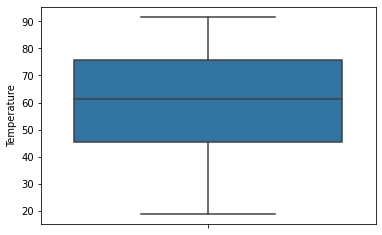

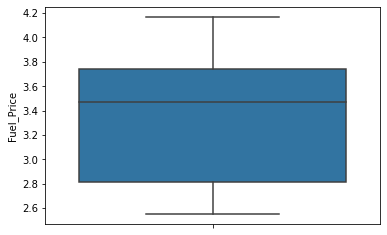

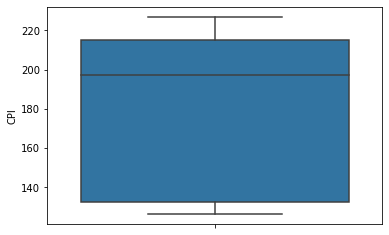

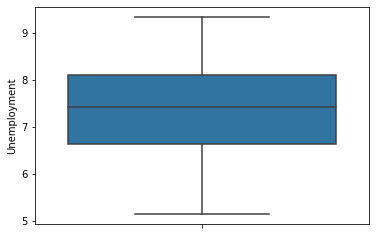

In [9]:
cols= ["Temperature","Fuel_Price","CPI","Unemployment"]
for k in cols:
    plt.figure()
    sns.boxplot(y=dataset[k])
    plt.show()
# la visualisation de boxplot nous permet de vérifier qu'il n'y a plus de valeurs abérrantes 

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         90 non-null     float64
 1   Date          80 non-null     object 
 2   Weekly_Sales  90 non-null     float64
 3   Holiday_Flag  90 non-null     float64
 4   Temperature   90 non-null     float64
 5   Fuel_Price    90 non-null     float64
 6   CPI           90 non-null     float64
 7   Unemployment  90 non-null     float64
dtypes: float64(7), object(1)
memory usage: 6.3+ KB


In [8]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Date']
# je convertis la colonne Date en datetime

0     2011-02-18
1     2011-03-25
4     2010-05-28
6     2011-03-06
7     2012-03-02
         ...    
139   2012-05-25
143   2010-04-06
144   2012-10-19
145   2010-06-18
149   2012-04-20
Name: Date, Length: 90, dtype: datetime64[ns]

In [9]:
dataset['year'] = dataset['Date'].dt.year
dataset['month']=dataset['Date'].dt.month
dataset['day']=dataset['Date'].dt.day
dataset['weekday'] = dataset['Date'].dt.dayofweek #(0 pr lundi et 6 pr dimanche)
dataset['dayofweek'] = dataset['Date'].dt.day_name()
dataset['nameofmonth'] = dataset['Date'].dt.month_name()
dataset=dataset.drop(columns="Date",axis=1)
dataset.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,weekday,dayofweek,nameofmonth
0,6.0,1572117.54,0.0,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,4.0,Friday,February
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,4.0,Friday,March
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,4.0,Friday,May
6,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,2011.0,3.0,6.0,6.0,Sunday,March
7,20.0,2203523.20,0.0,39.93,3.617,213.023623,6.961,2012.0,3.0,2.0,4.0,Friday,March


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 149
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         90 non-null     float64
 1   Weekly_Sales  90 non-null     float64
 2   Holiday_Flag  90 non-null     float64
 3   Temperature   90 non-null     float64
 4   Fuel_Price    90 non-null     float64
 5   CPI           90 non-null     float64
 6   Unemployment  90 non-null     float64
 7   year          80 non-null     float64
 8   month         80 non-null     float64
 9   day           80 non-null     float64
 10  weekday       80 non-null     float64
 11  dayofweek     80 non-null     object 
 12  nameofmonth   80 non-null     object 
dtypes: float64(11), object(2)
memory usage: 9.8+ KB


Visualisation

In [14]:
dataset_quanti=dataset[["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment","year","month","weekday"]]

corr_matrix = round(dataset_quanti.corr(),3)

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.values.tolist(),
                                  y = corr_matrix.index.values.tolist())
fig.show()
# il est utile de vérifier les corrélations non seulement entre les features mais aussi entre une feature et ma target, plus j'identifie
# qu'une feature et corrélée à ma target plus ça va me donner un indice que ma regression va marcher
# La corrélation on ne peut la calculer que entre les quantis, on peut dire qu'il y a une corrélation positive entre weekly_sales,
# weekday et l'unemployment.

In [15]:
px.scatter(dataset, x = 'Unemployment', y = 'Weekly_Sales')

In [16]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

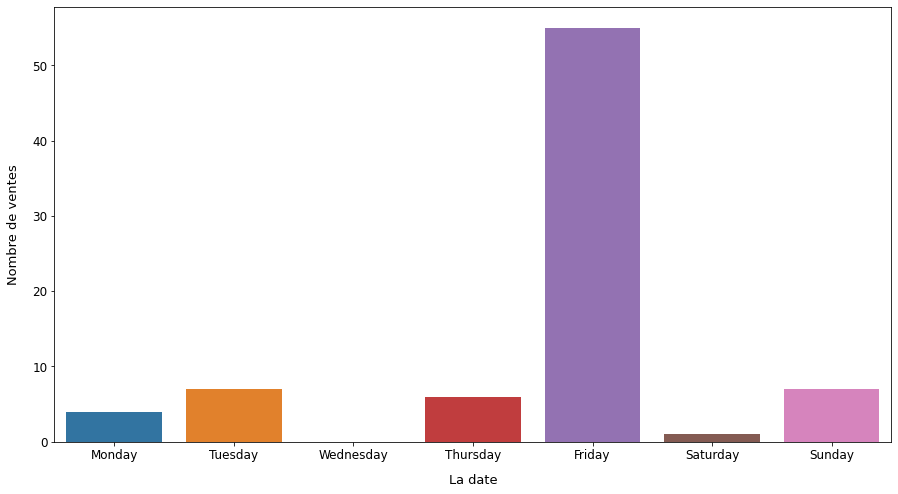

In [17]:
plt.figure(figsize=(15,8))
sns.countplot(data=dataset, x='dayofweek',order=day_order)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("La date",labelpad = 12, fontsize = 13)
plt.ylabel("Nombre de ventes",labelpad = 12, fontsize = 13)
plt.show()

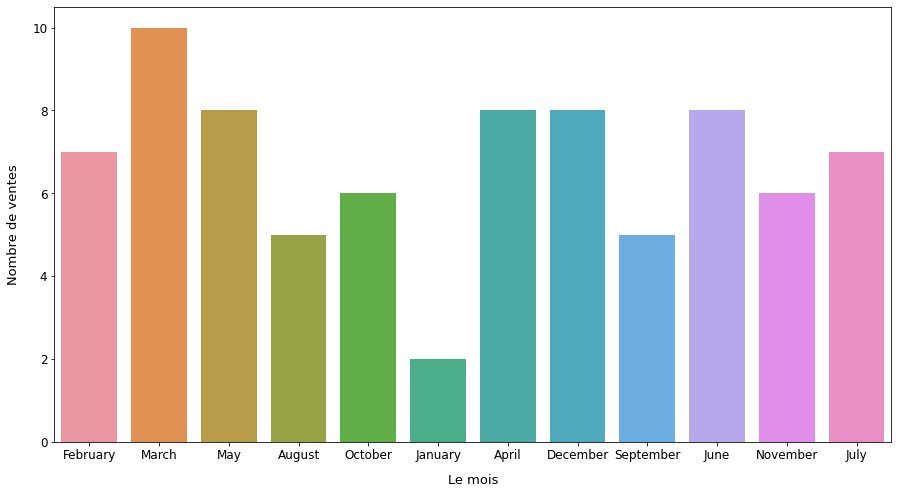

In [18]:
plt.figure(figsize=(15,8))
sns.countplot(data=dataset, x='nameofmonth')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Le mois",labelpad = 12, fontsize = 13)
plt.ylabel("Nombre de ventes",labelpad = 12, fontsize = 13)
plt.show()
# au mois de Mars y a le plus de vente 

<AxesSubplot:ylabel='Weekly_Sales'>

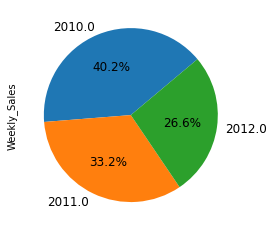

In [19]:
year_count = dataset.groupby(["year"])["Weekly_Sales"].sum()
year_count.plot.pie(autopct="%.1f%%", startangle=40, textprops={'fontsize': 12})

In [20]:
# Univariate analysis
from plotly.subplots import make_subplots

# Distribution of each numeric variable
num_features = ['Temperature', 'Fuel_Price','CPI','Unemployment']
#pour chacun des features 
fig1 = make_subplots(rows = len(num_features), cols = 1, subplot_titles = num_features)
for i in range(len(num_features)):
    fig1.add_trace(
        go.Histogram(
            x = dataset[num_features[i]], nbinsx = 15),
        row = i + 1,
        col = 1)
fig1.update_layout(
        title = go.layout.Title(text = "Distribution of quantitative variables", x = 0.5), showlegend = False, 
            autosize=False, height=500)
fig1.show()
# il boucle sur les features quantitative et fait un histogramme

In [21]:
# Univariate analysis
from plotly.subplots import make_subplots

# Barplot of each qualitative variable
cat_features = ['Store', 'Holiday_Flag']
fig2 = make_subplots(rows = len(cat_features), cols = 1, subplot_titles = cat_features)
for i in range(len(cat_features)):
    
    x_coords = dataset[cat_features[i]].value_counts().index.tolist()
    y_coords = dataset[cat_features[i]].value_counts().tolist()
    
    fig2.add_trace(
        go.Bar(
            x = x_coords,
            y = y_coords),
        row = i + 1,
        col = 1)
fig2.update_layout(
        title = go.layout.Title(text = "Barplot of qualitative variables", x = 0.5), showlegend = False, 
            autosize=False, height=500)
fig2.show()
# il boucle sur la liste des feautures catégorielles et pr chaque feature il va faire un barplot qui nous aide avoir s'il y a une 
# modalité qui est plus représenté qu'une autre on peut dire que le store 3 travaille le mieux et qu'il y a peu de jours fériés  

Preprocessing - Pandas 🐼🐼

In [10]:
dataset=dataset[["Store","Weekly_Sales","Holiday_Flag","Temperature","Fuel_Price","CPI","Unemployment","year","month","weekday"]]

In [11]:
def onehot_encoode(df,column,prefix):
    dummies=pd.get_dummies(dataset[column],prefix=prefix)
    df=pd.concat([df,dummies],axis=1)
    df=df.drop(column,axis=1)
    return df
# C'est la fonction qui va nous permettre d'encoder les stores et de supprimer la colonne de trop

In [12]:
dataset=onehot_encoode(dataset,column="Store",prefix="Sotre")
dataset

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,Sotre_1.0,...,Sotre_10.0,Sotre_11.0,Sotre_13.0,Sotre_14.0,Sotre_15.0,Sotre_16.0,Sotre_17.0,Sotre_18.0,Sotre_19.0,Sotre_20.0
0,1572117.54,0.0,59.61,3.045,214.777523,6.858,2011.0,2.0,4.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,4.0,0,...,0,0,1,0,0,0,0,0,0,0
4,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,4.0,0,...,0,0,0,0,0,0,0,0,0,0
6,695396.19,0.0,69.80,4.069,134.855161,7.658,2011.0,3.0,6.0,0,...,0,0,0,0,1,0,0,0,0,0
7,2203523.20,0.0,39.93,3.617,213.023623,6.961,2012.0,3.0,4.0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,532739.77,0.0,50.60,3.804,197.588605,8.090,2012.0,5.0,4.0,0,...,0,0,0,0,0,0,0,0,0,0
143,396968.80,0.0,78.53,2.705,214.495838,7.343,2010.0,4.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
144,424513.08,0.0,73.44,3.594,226.968844,6.034,2012.0,10.0,4.0,0,...,0,0,0,0,0,0,0,0,0,0
145,2248645.59,0.0,72.62,2.780,182.442420,8.899,2010.0,6.0,4.0,0,...,0,0,0,1,0,0,0,0,0,0


In [13]:
# Separate target variable Y from features X
target_name = 'Weekly_Sales'
print("Separating labels from features...")
Y = dataset.loc[:,target_name]
X = dataset.loc[:,[c for c in dataset.columns if c!=target_name]] # All columns are kept, except the target
print("...Done.")
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
0    1572117.54
1    1807545.43
4    1644470.66
6     695396.19
7    2203523.20
Name: Weekly_Sales, dtype: float64

   Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment    year  \
0           0.0        59.61       3.045  214.777523         6.858  2011.0   
1           0.0        42.38       3.435  128.616064         7.470  2011.0   
4           0.0        78.89       2.759  212.412888         7.092  2010.0   
6           0.0        69.80       4.069  134.855161         7.658  2011.0   
7           0.0        39.93       3.617  213.023623         6.961  2012.0   

   month  weekday  Sotre_1.0  Sotre_2.0  ...  Sotre_10.0  Sotre_11.0  \
0    2.0      4.0          0          0  ...           0           0   
1    3.0      4.0          0          0  ...           0           0   
4    5.0      4.0          0          0  ...           0           0   
6    3.0      6.0          0          0  ...           0           0   
7    3.0   

In [14]:
X.head(1)

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,Sotre_1.0,Sotre_2.0,...,Sotre_10.0,Sotre_11.0,Sotre_13.0,Sotre_14.0,Sotre_15.0,Sotre_16.0,Sotre_17.0,Sotre_18.0,Sotre_19.0,Sotre_20.0
0,0.0,59.61,3.045,214.777523,6.858,2011.0,2.0,4.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X = X.values
Y= Y.tolist()
print("...Done")
print(X[0:5,:])
print()
print(Y[0:5])

Convert pandas DataFrames to numpy arrays...
...Done
[[0.00000000e+00 5.96100000e+01 3.04500000e+00 2.14777523e+02
  6.85800000e+00 2.01100000e+03 2.00000000e+00 4.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.23800000e+01 3.43500000e+00 1.28616064e+02
  7.47000000e+00 2.01100000e+03 3.00000000e+00 4.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.88900000e+01 2.75900000e+00 2.12412888e+02
  7.09200000e+00 2.01000000e+03 5.00000000e+0

In [16]:
# First : always divide dataset into train set & test set !!
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [17]:
# Create pipeline for numeric features
numeric_features = [1,2,3,4,5,6,7] # Positions of numeric columns in X
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = numeric_transformer 

In [18]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test) # Don't fit again !!
print('...Done.')
print(X_test[0:5,:])
print()
#On est entrain de préparer les données avant de les mettre dans le modèle 

Performing preprocessings on train set...
[[0.00000000e+00 6.17900000e+01 2.71100000e+00 1.89523128e+02
  6.86800000e+00 2.01000000e+03 9.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.91700000e+01 3.59400000e+00 2.24019287e+02
  5.42200000e+00 2.01200000e+03 1.00000000e+01 4.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.32600000e+01 3.78900000e+00 1.33958742e+02
  7.77100000e+00 2.01100000e+03 3.00000000e+00 4.0000000

Linear Regression

In [32]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")
#Le modèle détermine les meilleurs coefficients pr prédire Y. A ce moment là les coef sont figés pr pouvoir faire des prédictions

Train model...
...Done.


In [33]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[ 614643.49412189  371134.40579841 1330843.3957801   871024.07564963
 1535240.22330821 1592716.77127139 1996072.46518457  643512.44768569
  926259.61331296 1094817.20461609 2060070.70572078  559838.89894932
 2066450.25690005  585283.21401655  532274.39928691  819984.97967991
  670131.513365   1626569.10564377  248530.03104764  540489.51321838
 1815129.1815554  2040780.58505904 1124102.10861753 1397863.50615842
 2063654.32948615 1986553.93781555  433629.56900677 2075983.75340788
  895012.69875318 1594862.20329567 1955975.40735739 1580192.22933551
 1587850.08899831 1853847.89973219  377824.70737442  484506.60500664
  833429.09860419 1410346.85532406 1985013.49631158 2041212.74805218
  509413.6574641  2033555.26376778 1486628.61396142  422687.93132762
  226787.3493538   525299.79959496  435007.02587811 1880522.47843429
 2032035.81863149  434442.40497369 2072576.84790587 1908205.25825728
  853410.2917159  1526844.33770601  493290.20177498  344885.243

In [34]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[1601189.03996916  593283.85501469 1847268.5482564  1712619.23717348
  470175.66493971  320593.34745701 1226930.05329673 2133675.39323944
 2001580.35086303 1369842.32506905 1155467.15869197 1041549.53369671
  532930.27042184  394603.19773335  458359.00425421 1443382.05238092
 2098106.32943881  486902.11498331]



In [35]:
# Print R² scores
print("R² score on training set : ", r2_score(Y_train, Y_train_pred))
print("R² score on test set : ", r2_score(Y_test, Y_test_pred))
# Pour savoir si notre modèle overfitte ou pas on doit faire une cross_validation 

R² score on training set :  0.9830518663100385
R² score on test set :  0.9310645782398248


In [36]:
# Cross_validation
scores= cross_val_score(regressor, X_train, Y_train, cv=10)
print('The cross-validated score is:{:.3f}'.format(scores.mean()))
print('The standard deviation is:{:.3f}'.format(scores.std()))
# un modèle de regression sur ces datas va me donner en général un R² score de 0.95 et que ça va varier d'environ 0.026

The cross-validated score is:0.950
The standard deviation is:0.026


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



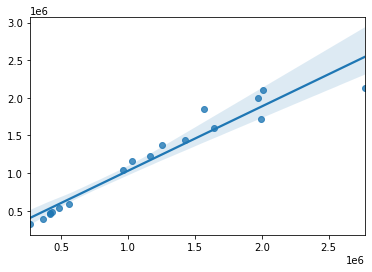

In [37]:
sns.regplot(Y_test, Y_test_pred)
plt.show()

In [38]:
regressor.coef_

array([-1.24013579e+04,  2.39797298e+02, -7.15057715e+04,  8.39043766e+05,
        4.35216367e+04, -4.99794450e+03, -3.53847521e+03, -2.52123209e+04,
       -1.21150655e+05, -3.59608910e+04, -4.65565153e+05,  4.16020154e+05,
       -3.79119490e+05, -7.94504346e+04, -2.61984614e+05, -2.54464585e+05,
       -3.08810115e+05,  3.26874905e+05, -3.19299868e+04,  5.33944287e+05,
        1.46515869e+05,  8.92781942e+04, -1.54192856e+05,  1.50308687e+05,
        1.81877401e+05,  2.64044933e+05,  4.00818830e+04])

In [39]:
coefs = pd.DataFrame( index=dataset.columns[1:29],data = regressor.coef_.transpose(), columns=["coefficients"])
coefs

,coefficients
Holiday_Flag,-12401.357914
Temperature,239.797298
Fuel_Price,-71505.771511
CPI,839043.765882
Unemployment,43521.636656
year,-4997.944497
month,-3538.475206
weekday,-25212.320948
Sotre_1.0,-121150.654929
Sotre_2.0,-35960.890962


In [40]:
coefs.apply(lambda x : abs(x)).sort_values(by="coefficients", ascending=False)

,coefficients
CPI,839043.765882
Sotre_13.0,533944.287200
Sotre_3.0,465565.153276
Sotre_4.0,416020.153969
Sotre_5.0,379119.489765
Sotre_10.0,326874.904502
Sotre_9.0,308810.114927
Sotre_19.0,264044.933036
Sotre_7.0,261984.613563
Sotre_8.0,254464.584598


Ridge 

In [21]:
ridge = Ridge()
ridge.fit(X_train, Y_train)
print('Train score of ridge: {:.3f}'.format(ridge.score(X_train, Y_train)))
print('Test score of ridge: {:.3f}'.format(ridge.score(X_test, Y_test)))

Train score of ridge: 0.981
Test score of ridge: 0.932


In [23]:
# Cross_validation
scores_ridge = cross_val_score(ridge, X_train, Y_train, cv=10)
print('The cross-validated score is:{:.3f}'.format(scores_ridge.mean()))
print('The standard deviation is:{:.3f}'.format(scores_ridge.std()))

The cross-validated score is:0.939
The standard deviation is:0.047


Grid Search

In [42]:
# Perform grid search

print("Grid search...")
# Grid of values to be tested
params = {
    'alpha': [0.0, 0.1, 0.5, 1.0] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(ridge, param_grid = params, cv = 10) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.1}


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning:

Ill-conditioned matrix (rcond=1.03721e-16): result may not be accurate.

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning:

Ill-conditioned matrix (rcond=8.11064e-17): result may not be accurate.

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning:

Ill-conditioned matrix (rcond=4.90365e-18): result may not be accurate.



In [46]:
#Print R² scores on train/test sets for the Ridge model with optimal value of the regularization strength
print("R² score on training set : {:.3f}".format(gridsearch.score(X_train, Y_train)))
print("R² score on test set : {:.3f}".format(gridsearch.score(X_test, Y_test)))

R² score on training set : 0.982
R² score on test set : 0.935


Lasso

In [39]:
lasso = Lasso()
lasso.fit(X_train, Y_train)
print('Train score of ridge: {:.3f}'.format(lasso.score(X_train, Y_train)))
print('Test score of ridge: {:.3f}'.format(lasso.score(X_test, Y_test)))

Train score of ridge: 0.983
Test score of ridge: 0.933


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 258885497940.51547, tolerance: 3009808860.5723906



Grid Search

In [25]:
lasso1 = Lasso(alpha = 1)
lasso001 = Lasso(alpha = 0.01)
lasso00001 = Lasso(alpha = 0.0001)

In [26]:
lasso1.fit(X_train, Y_train)
lasso001.fit(X_train, Y_train)
lasso00001.fit(X_train, Y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 258885497940.51547, tolerance: 3009808860.5723906

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 259949688977.13312, tolerance: 3009808860.5723906

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 259960294666.3856, tolerance: 3009808860.5723906



Lasso(alpha=0.0001)

In [36]:
print("Score Lasso1 : {} \nScore Lasso001 : {} \nScore Lasso00001 : {}".format(lasso1.score(X_train, Y_train),
lasso001.score(X_train, Y_train),
lasso00001.score(X_train,Y_train)))

Score Lasso1 : 0.982723303771656 
Score Lasso001 : 0.9827257618616176 
Score Lasso00001 : 0.9827257864159554


In [37]:
print("Score Lasso1 : {} \nScore Lasso001 : {} \nScore Lasso00001 : {}".format(lasso1.score(X_test, Y_test),
lasso001.score(X_test, Y_test),
lasso00001.score(X_test,Y_test)))

Score Lasso1 : 0.9333945528659369 
Score Lasso001 : 0.9333858688848655 
Score Lasso00001 : 0.933385781924049


In [ ]:
# Le milleur alpha =1 

In [ ]:
# Notre meilleur modèle qui nous donne le meilleur score sur le test est le modèle ridge avec grid search 